# AMAL : TP2

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

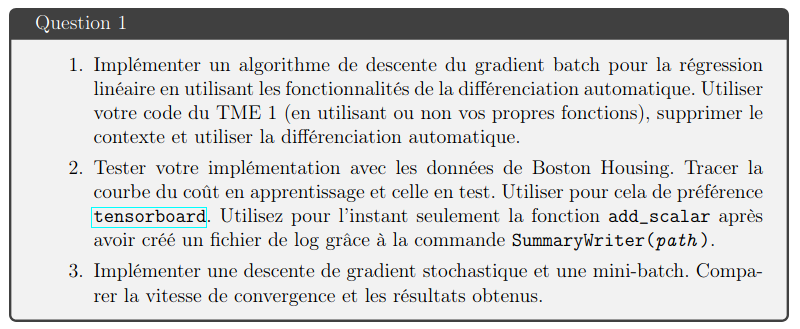

In [64]:
a = torch.rand((1,10),requires_grad=True)
b = torch.rand((1,10),requires_grad=True)
c = a.mm(b.t())
d = 2 * c
c.retain_grad() # on veut conserver le gradient par rapport à c
d.backward() ## calcul du gradient et retropropagation
##jusqu’aux feuilles du graphe de calcul
print(d.grad) #Rien : le gradient par rapport à d n’est pas conservé
print(c.grad) # Celui-ci est conservé
print(a.grad) ## gradient de d par rapport à a qui est une feuille
print(b.grad) ## gradient de d par rapport à b qui est une feuille
d = 2 * a.mm(b.t())
d.backward()
print(a.grad) ## 2 fois celui d’avant, le gradient est additioné
a.grad.data.zero_() ## reinitialisation du gradient pour a
d = 2 * a.mm(b.t())
d.backward()
print(a.grad) ## Cette fois, c’est ok
with torch.no_grad():
    c = a.mm(b.t()) ## Le calcul est effectué sans garder le graphe de calcul
# c.backward() ## Erreur

None
tensor([[2.]])
tensor([[1.2015, 0.0214, 1.6367, 1.1158, 0.0664, 0.7175, 0.5500, 1.8965, 0.0664,
         0.8430]])
tensor([[0.7893, 0.5156, 0.8450, 1.0809, 1.4509, 1.4371, 0.1384, 1.3531, 0.2284,
         0.5368]])
tensor([[2.4031, 0.0428, 3.2735, 2.2315, 0.1328, 1.4349, 1.1000, 3.7929, 0.1329,
         1.6860]])
tensor([[1.2015, 0.0214, 1.6367, 1.1158, 0.0664, 0.7175, 0.5500, 1.8965, 0.0664,
         0.8430]])


In [113]:
from torch.autograd import Function

class MSE(Function):
    @staticmethod
    def forward(yhat, y):
        return torch.mean((yhat - y)**2,dim=0)


class Linear(Function) :
    @staticmethod
    def forward(X, W, B):
        return X @ W + B

    
n_data = 100
n_features = 1
nb_iter = 100000
learning_rate = 0.0001

x = torch.randn(n_data,n_features , requires_grad=True)
y = torch.randn(n_data,1 , requires_grad=True)
w = torch.randn(n_features,1 , requires_grad=True)
b = torch.randn(1 , requires_grad=True)



list_loss = list()

for i in tqdm(range(nb_iter)) : 
    y_pred = Linear.forward(x,w,b)
    loss = MSE.forward(y_pred,y)
    
    list_loss.append(loss.detach().numpy())
    
    loss.backward()
    
    grad_w = w.grad
    grad_b = b.grad
    
    with torch.no_grad() :
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b
        
    w.grad.data.zero_()
    b.grad.data.zero_()
    

100%|█████████████████████████████████| 100000/100000 [00:19<00:00, 5065.78it/s]


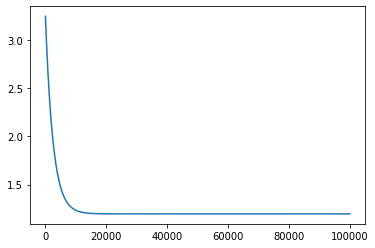

In [114]:
plt.figure()
plt.plot(list_loss)
plt.show()

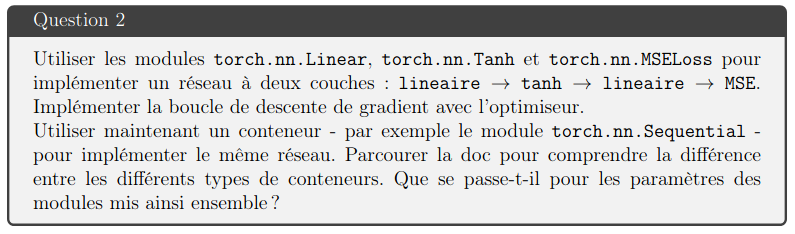

In [55]:
class Network(nn.Module) : 
    
    
    def __init__(self,
                n_features : int,
                nb_neurons : int 
                ) : 
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_features,nb_neurons),
            nn.Tanh(),
            nn.Linear(nb_neurons,1)
        )
        
    def forward(self,x) :
        return self.net(x)

In [56]:
n_data = 100
n_features = 1
nb_iter = 100000

x = torch.randn((n_data,n_features))
y = torch.randn((n_data,1))

network = Network(
    n_features = n_features,
    nb_neurons = 50
)

optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)

print(network(x).shape)

torch.Size([100, 1])


In [57]:
list_loss = list()

for i in tqdm(range(nb_iter)) : 
    y_pred = network(x)
    mse = torch.nn.MSELoss()
    loss = mse(y_pred,y)
    list_loss.append(loss.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|█████████████████████████████████| 100000/100000 [01:02<00:00, 1604.46it/s]


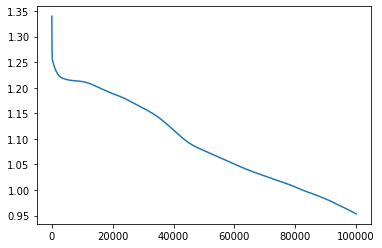

In [58]:
plt.figure()
plt.plot(list_loss)
plt.show()

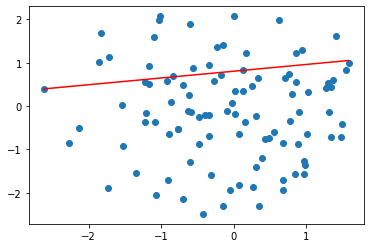

In [59]:
x_data = x.detach().numpy()
y_data = y.detach().numpy()

plt.figure()
plt.scatter(x_data,y_data)
plt.plot(  [min(x_data),max(x_data)] , [network(torch.min(x).reshape(1,1)).detach().numpy().reshape(1),network(torch.max(x).reshape(1,1)).detach().numpy().reshape(1)   ] ,color="r"  )
plt.show()